# City Clusters: Non-Spatial Proximity
### Searching for cities similar to a geographical point of reference based on venues categories in its vicinity. 



## Introduction

    Suppose a tourist from Sao Paulo wants to spend some time in a city abroad. He thinks having to process phrases in a foreign language is enough work for his vacationing brain so he wants to find cities that can make him feel as “home” as possible. He is concerned about the diversity and availability of transportation, the services around his residence that he is used to hire, the entertainment he enjoys, etc. The present work proposes to find a systematic way to assess the existence of a Sao Paulo “twin” in the United States, and check if that country is a good choice of destination based on this criterion. 
    The rationale is translational for other business problems where one has a great number of features of unknown structure or relationship among the variables.

    In this project we will use the categories of venues available at the Foursquare API "Places" as features for the areas. Then we will partition these data objects into groups according to similarities (or lack thereof) using a distance criterion in order to define clusters containing cities that are similar. The model we will use here is the HDBSCAN, which makes no assumptions as to the shape or density of the clusters.  



#### Workflow: 



1. Data

    - Get the coordinates of all locations to be compared.  
    - Get the venues and their categories from the Foursquare API
    - Format the data using one-hot encoding. 
    - Scale the data for compatibility with the model.


2. Modeling

    - Dimensionality reduction with PCA
    - Training the model for clusters - HDBSCAN
    

3. Evaluation

    - Assessment and visualization of the clusters.


4. Conclusion




## Importing Libraries




In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
import requests
import geocoder
import folium
from geopy.geocoders import Nominatim

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import sklearn
import hdbscan
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 



## Data



#### Create a function to get the coordinates (latitude and longitude) of a location name. 

In [2]:

def get_coordinates(geographical_name):
    '''
    This function takes in a city name, country name or address in the format <street>, <city>, <country> and returns the latitude and longitude. 
    '''
    try: 
        partial_address = geographical_name
        geolocator = Nominatim(user_agent="my-application")
        location = geolocator.geocode(partial_address, addressdetails=True)
        latitude = location.latitude 
        longitude = location.longitude
        
        return float(latitude), float(longitude)
    except: 
        return None, None 
        

In [3]:
# Define the object for the location of the tourist and create a dataframe with the location name, its population, latitude and longitude. 

home = 'Avenida Paulista, Sao Paulo, Brazil'
home_population = 12000000
home_lat, home_lng = get_coordinates(home)

home_df = pd.DataFrame([[home, home_population, home_lat, home_lng]], columns = ['city', 'population', 'latitude', 'longitude'])
home_df

city  population  latitude  longitude
0  Avenida Paulista, Sao Paulo, Brazil    12000000   -23.557 -46.661248

#### Get the list of cities to be compared. I'm using the biggest cities in the United States according to the URL below. 

In [4]:

 # Define the list of cities in the country to be visited, select only the features of interest and then get the latitude and longitude for each city. 

url = " https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population"
req = requests.get(url)
page = bs(req.content)
table = page.find('table', {'class': "wikitable sortable"})
df_abroad = pd.read_html(str(table), header = 0)[0]
df_abroad.head(10)

# Let's remove the unnecessary features...
df_abroad = df_abroad.drop(['2019rank', '2010Census', 'Change', '2016 land area', '2016 population density', '2016 population density.1', 'Location', '2016 land area.1'], axis = 1)

# ...rename the 2020 Estimate to "population" and the "City" to "city"...
df_abroad = df_abroad.rename(columns = {'2019estimate': 'population', 'City': 'city'})

# ...and pick only the cities with more than 50000 inhabitants to create a new DataFrame. 
# df_abroad_50K = df_abroad[df_abroad['population'] >= 50000]

# ...and make sure all cities will be in Italy, since some of the city names are also used for geography in other countries. 
df_abroad['city'] = df_abroad['city'].astype(str) + ', ' + df_abroad['State[c]'].astype(str) #+ ', US'

df_abroad = df_abroad.drop(['State[c]'], axis = 1)

# Then we use the city names to get the latitude and longitude using the get_coordinates() function. 
cities_list = df_abroad.city.tolist()

# Now we pass the list of city names to the function get_coordinates():

lat_list = []
lng_list = []

for i in cities_list:
    coord = get_coordinates(i)
    lat_list.append(coord[0]), lng_list.append(coord[1])


In [5]:
# We can now add the lat_list and lng_list to the df_abroad dataframe, and add the home location creating a unified dataframe of all cities: 

df = df_abroad
df['latitude'] = pd.to_numeric(lat_list, errors = 'coerce', downcast = 'float')
df['longitude'] = pd.to_numeric(lng_list, errors = 'coerce', downcast = 'float')

# Now we add the home town of the tourist

df = df.append(home_df, ignore_index = True)
df = df.dropna()
df = df.reset_index(drop=True)

df.head()

city  population   latitude   longitude
0  Los Angeles, California     3979576  34.053692 -118.242767
1        Chicago, Illinois     2693976  41.875561  -87.624420
2         Phoenix, Arizona     1680992  33.448437 -112.074142
3       San Antonio, Texas     1547253  29.424601  -98.495140
4    San Diego, California     1423851  32.717422 -117.162773

#### Let's check out the cities in the map. 



In [6]:

map_cities = folium.Map(location=[df['latitude'][0], df['longitude'][0]], zoom_start=4)
# add markers to map
for lat, lng, cit in zip(df['latitude'], df['longitude'], df['city']): 
    label = '{}'.format(cit)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_cities)  
    
map_cities



### Get venues data from the Foursquare API...



In [7]:
# Define my credentials from a local .csv file
# In order to have the data without the interference of the covid-19 pandemics I decided to have the "Version" to October, 20, 2019. "20191020". Just an arbitrary date before the virus had caused changes in lifestyle and economy. 

CLIENT_ID, CLIENT_SECRET, VERSION = pd.read_csv('credentials.csv')

In [8]:
def get4sqURL(lat, lng, radius=5000, LIMIT = 2000):
    '''
    This function takes latitude, longitude, maximum number of searches and radius and returns the url for that search on the FourSquare API
    To limit the number of unique categories to take into acount as features for comparison we will remove the restaurants. We are then comparing the cities with respect to the remaining venues 

    '''

    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId=4d4b7104d754a06370d81259,4d4b7105d754a06372d81259,4d4b7105d754a06373d81259,4d4b7105d754a06376d81259,4d4b7105d754a06377d81259,4d4b7105d754a06375d81259,4d4b7105d754a06378d81259,4d4b7105d754a06379d81259&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    lat, 
    lng, 
    radius, 
    LIMIT)
    return url
    


In [9]:
def getNearbyVenues(names, latitudes, longitudes, radius=10000):
    '''
    This function takes the location name, coordinates and radius and outputs the venues around the locations. 
    '''
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = get4sqURL(lat,lng,radius)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        
        venues_list.append([(
        name, 
        lat, 
        lng, 
        v['venue']['name'], 
        v['venue']['location']['lat'], 
        v['venue']['location']['lng'],  
        v['venue']['categories'][0]['name']) for v in results])
    
        

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['city', 
                    'city latitude', 
                    'city longitude', 
                    'venue', 
                    'venue latitude', 
                    'venue longitude', 
                    'venue category']
    
    return(nearby_venues)

In [ ]:
# DataFrame containing all the venues listed in within the "radius" up to the limit of the API.


    all_venues = getNearbyVenues(names=df['city'], 
                                   latitudes=df['latitude'], 
                                   longitudes=df['longitude'], 
                                   radius=10000)    
    

In [10]:
all_venues = pd.read_csv('all_venues_10000meters_nofood_USmega.csv')
all_venues = all_venues.dropna()


In [11]:
all_venues.head(10)

Unnamed: 0                     city  city latitude  city longitude  \
0           0  Los Angeles, California      34.053692     -118.242767   
1           1  Los Angeles, California      34.053692     -118.242767   
2           2  Los Angeles, California      34.053692     -118.242767   
3           3  Los Angeles, California      34.053692     -118.242767   
4           4  Los Angeles, California      34.053692     -118.242767   
5           5  Los Angeles, California      34.053692     -118.242767   
6           6  Los Angeles, California      34.053692     -118.242767   
7           7  Los Angeles, California      34.053692     -118.242767   
8           8  Los Angeles, California      34.053692     -118.242767   
9           9  Los Angeles, California      34.053692     -118.242767   

                            venue  venue latitude  venue longitude  \
0        Walt Disney Concert Hall       34.055511      -118.249284   
1       Dorothy Chandler Pavilion       34.056625      -118.248886   
2                       The Broad       34.054474      -118.250051   
3                Ahmanson Theatre       34.058145      -118.247434   
4        Los Angeles Music Center       34.057133      -118.248354   
5                  Hauser & Wirth       34.046095      -118.234801   
6                Mark Taper Forum       34.057640      -118.247977   
7  The Geffen Contemporary (MoCA)       34.050486      -118.238777   
8              The Container Yard       34.043176      -118.236745   
9                  Blue Whale Bar       34.049884      -118.242114   

          venue category  
0           Concert Hall  
1  Performing Arts Venue  
2             Art Museum  
3                Theater  
4            Music Venue  
5            Art Gallery  
6                Theater  
7            Art Gallery  
8            Art Gallery  
9              Jazz Club

In [12]:
print('There are {} unique categories of venues in the {} locations considered.'.format(len(all_venues['venue category'].unique()), len(all_venues['city'].unique())))

There are 41 unique categories of venues in the 281 locations considered.


#### Create a one-hot-encoded dataframe of all unique venue categories in the locations

In [13]:
# one hot encoding
cat_onehot = pd.get_dummies(all_venues[['venue category']], prefix="", prefix_sep="")

# add city column back to dataframe
cat_onehot['city'] = all_venues['city'] 

# move city column to the first column
fixed_columns = [cat_onehot.columns[-1]] + list(cat_onehot.columns[:-1])
cat_onehot = cat_onehot[fixed_columns]

# group de rows by city and sum the occurences of each category. The sum was chosen because the API is not consistent as to the total number of outputs per city, which makes the mean() to be not consistent for comparison. 
cities_grouped = cat_onehot.groupby('city').sum().reset_index()

cities_grouped.head(15)


city  Amphitheater  Art Gallery  Art Museum  \
0            Abilene, Texas             0            2           0   
1               Akron, Ohio             0            6           1   
2   Albuquerque, New Mexico             0            6           1   
3              Allen, Texas             0            2           0   
4   Allentown, Pennsylvania             0            6           1   
5           Amarillo, Texas             0            2           0   
6       Anaheim, California             0            8           1   
7       Ann Arbor, Michigan             1            8           2   
8       Antioch, California             0            0           0   
9          Arlington, Texas             0            2           0   
10         Arvada, Colorado             0            4           0   
11         Atlanta, Georgia             0           15           3   
12         Aurora, Colorado             0            1           0   
13         Aurora, Illinois             0            2           0   
14            Austin, Texas             0            9           5   

    Arts & Entertainment  Circus  Comedy Club  Concert Hall  \
0                      1       0            0             1   
1                      0       0            1             0   
2                      0       0            0             2   
3                      0       0            0             1   
4                      0       0            0             0   
5                      2       0            0             1   
6                      1       0            2             3   
7                      1       0            1             3   
8                      0       0            0             1   
9                      1       0            1             2   
10                     0       0            0             0   
11                     0       1            4             3   
12                     0       0            1             0   
13                     0       0            2             0   
14                     0       0            5             1   

    Country Dance Club  Dance Studio  ...  Rock Club  Roller Rink  \
0                    0             3  ...          1            0   
1                    0             6  ...          0            0   
2                    0             6  ...          0            0   
3                    0            11  ...          0            1   
4                    1            10  ...          0            0   
5                    0             4  ...          1            0   
6                    1             8  ...          4            0   
7                    0             9  ...          1            0   
8                    0             9  ...          0            0   
9                    0             4  ...          1            0   
10                   0             5  ...          0            0   
11                   0             3  ...          1            0   
12                   0             8  ...          1            0   
13                   1            16  ...          0            1   
14                   0             5  ...          8            0   

    Rugby Stadium  Salsa Club  Samba School  Science Museum  Street Art  \
0               0           0             0               0           0   
1               0           0             0               0           0   
2               0           0             0               2           0   
3               0           0             0               0           0   
4               0           0             0               0           0   
5               0           0             0               1           0   
6               0           0             0               1           0   
7               0           0             0               1           0   
8               0           0             0               0           0   
9               0           0         

In [14]:
# We can see the descriptive statistics for each feature. 

cities_grouped.describe()

Amphitheater  Art Gallery  Art Museum  Arts & Entertainment  \
count    281.000000   281.000000  281.000000            281.000000   
mean       0.245552     5.654804    1.014235              0.658363   
std        0.560793     5.827127    1.426713              0.826358   
min        0.000000     0.000000    0.000000              0.000000   
25%        0.000000     2.000000    0.000000              0.000000   
50%        0.000000     4.000000    1.000000              0.000000   
75%        0.000000     8.000000    1.000000              1.000000   
max        4.000000    40.000000    9.000000              3.000000   

           Circus  Comedy Club  Concert Hall  Country Dance Club  \
count  281.000000   281.000000    281.000000          281.000000   
mean     0.074733     0.654804      1.683274            0.163701   
std      0.289276     1.054778      1.980991            0.424558   
min      0.000000     0.000000      0.000000            0.000000   
25%      0.000000     0.000000      0.000000            0.000000   
50%      0.000000     0.000000      1.000000            0.000000   
75%      0.000000     1.000000      3.000000            0.000000   
max      2.000000     6.000000      9.000000            2.000000   

       Dance Studio   Disc Golf  ...   Rock Club  Roller Rink  Rugby Stadium  \
count    281.000000  281.000000  ...  281.000000    281.00000     281.000000   
mean       7.056940    1.064057  ...    1.032028      0.13879       0.003559   
std        4.340461    1.246204  ...    1.454932      0.38539       0.059655   
min        0.000000    0.000000  ...    0.000000      0.00000       0.000000   
25%        4.000000    0.000000  ...    0.000000      0.00000       0.000000   
50%        6.000000    1.000000  ...    1.000000      0.00000       0.000000   
75%       10.000000    2.000000  ...    1.000000      0.00000       0.000000   
max       22.000000    6.000000  ...    8.000000      2.00000       1.000000   

       Salsa Club  Samba School  Science Museum  Street Art     Theater  \
count  281.000000    281.000000      281.000000  281.000000  281.000000   
mean     0.017794      0.003559        0.644128    0.049822    6.992883   
std      0.132436      0.059655        1.112290    0.248585    4.768193   
min      0.000000      0.000000        0.000000    0.000000    0.000000   
25%      0.000000      0.000000        0.000000    0.000000    4.000000   
50%      0.000000      0.000000        0.000000    0.000000    6.000000   
75%      0.000000      0.000000        1.000000    0.000000    9.000000   
max      1.000000      1.000000        8.000000    2.000000   28.000000   

       Tour Provider  Zoo Exhibit  
count     281.000000   281.000000  
mean        0.601423     1.320285  
std         1.935901     4.153817  
min         0.000000     0.000000  
25%         0.000000     0.000000  
50%         0.000000     0.000000  
75%         1.000000     0.000000  
max        26.000000    35.000000  

[8 rows x 41 columns]

In [15]:
## Get the most prevalent venues in each city. 

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [16]:
num_top_venues = 15

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['city']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cities_venues_sorted = pd.DataFrame(columns=columns)
cities_venues_sorted['city'] = cities_grouped['city']

for ind in np.arange(cities_grouped.shape[0]):
    cities_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cities_grouped.iloc[ind, :], num_top_venues)

cities_venues_sorted.head(10)

city 1st Most Common Venue 2nd Most Common Venue  \
0           Abilene, Texas         Movie Theater          Dance Studio   
1              Akron, Ohio           Music Venue          Dance Studio   
2  Albuquerque, New Mexico               Theater         Movie Theater   
3             Allen, Texas          Dance Studio           Music Venue   
4  Allentown, Pennsylvania               Theater          Dance Studio   
5          Amarillo, Texas         Movie Theater               Theater   
6      Anaheim, California               Theater         Movie Theater   
7      Ann Arbor, Michigan          Dance Studio           Music Venue   
8      Antioch, California          Dance Studio         Movie Theater   
9         Arlington, Texas           Music Venue         Movie Theater   

  3rd Most Common Venue 4th Most Common Venue  5th Most Common Venue  \
0               Theater           Art Gallery         History Museum   
1               Theater           Art Gallery          Movie Theater   
2        History Museum           Art Gallery           Dance Studio   
3         Movie Theater             Disc Golf                Theater   
4           Music Venue        History Museum            Art Gallery   
5          Dance Studio                Museum            Art Gallery   
6           Art Gallery          Dance Studio            Music Venue   
7           Art Gallery         Movie Theater                Theater   
8               Theater             Multiplex            Music Venue   
9          Dance Studio                Museum  Performing Arts Venue   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0                 Museum             Disc Golf          Concert Hall   
1         History Museum   Indie Movie Theater                Museum   
2            Music Venue         Tour Provider                Museum   
3         History Museum   Indie Movie Theater           Art Gallery   
4          Movie Theater                Museum             Disc Golf   
5         History Museum  Arts & Entertainment             Multiplex   
6  Performing Arts Venue        History Museum             Rock Club   
7           Concert Hall             Disc Golf                Museum   
8           Concert Hall        History Museum               Exhibit   
9                Theater           Art Gallery             Multiplex   

   9th Most Common Venue 10th Most Common Venue 11th Most Common Venue  \
0              Rock Club      Outdoor Sculpture            Music Venue   
1  Performing Arts Venue          Tour Provider              Jazz Club   
2             Public Art           Concert Hall            Zoo Exhibit   
3            Roller Rink           Concert Hall              Multiplex   
4  Performing Arts Venue     Country Dance Club              Jazz Club   
5            Music Venue         Science Museum          Memorial Site   
6                 Museum           Concert Hall            Comedy Club   
7             Art Museum         History Museum  Performing Arts Venue   
8              Jazz Club          Indie Theater    Indie Movie Theater   
9           Concert Hall             Public Art          Go Kart Track   

  12th Most Common Venue 13th Most Common Venue 14th Most Common Venue  \
0   Arts & Entertainment              Mini Golf            Comedy Club   
1            Comedy Club             Art Museum              Laser Tag   
2         Science Museum    Indie Movie Theater          Indie Theater   
3     Country Dance Club              Laser Tag             Art Museum   
4      Outdoor Sculpture              Multiplex             Art Museum   
5      Outdoor Sculpture  Performing Arts Venue           Concert Hall   
6            Opera House          Go Kart Track          Memorial Site   
7   Arts & Entertainment            Comedy Club              Laser Tag   
8          Go Kart Track              Disc Golf       Drive-in Theater   
9          Tour Provider              Piano Bar            Planeta

Let's take a look at the distribution of Concerd Halls in all cities to have a sense of its shape. 

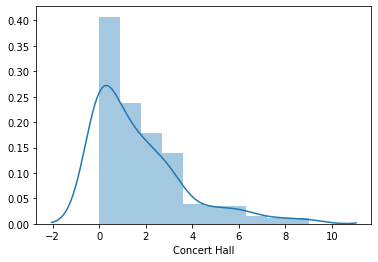

In [17]:
sns.distplot(cities_grouped['Concert Hall'])

## Modeling






### Dimensionality reduction


There are too many features in this dataframe, so we will reduce them to the components that explain most of the variance in the data. This is done by a Principal Components Analysis, in which we find a lower-dimensional representation for the data.

Because PCA is sensitive to different variabiities we will first scale all features. 

In [36]:
cities_grouped_merge_population = pd.merge(left = cities_grouped, right = df, left_on='city', right_on='city', how = 'left')
cities_grouped_merge_population = cities_grouped_merge_population.drop(['latitude', 'longitude'], axis = 1)
cities_grouped_merge_population = cities_grouped_merge_population.dropna()

# Create a new dataframe containing the features for all venues. 
venues_features = cities_grouped_merge_population.iloc[:,1:]
venues_features = venues_features.dropna()
venues_features.head(10)

Amphitheater  Art Gallery  Art Museum  Arts & Entertainment  Circus  \
0             0            2           0                     1       0   
1             0            6           1                     0       0   
2             0            6           1                     0       0   
3             0            2           0                     0       0   
4             0            6           1                     0       0   
5             0            2           0                     2       0   
6             0            8           1                     1       0   
7             1            8           2                     1       0   
8             0            0           0                     0       0   
9             0            2           0                     1       0   

   Comedy Club  Concert Hall  Country Dance Club  Dance Studio  Disc Golf  \
0            0             1                   0             3          2   
1            1             0                   0             6          0   
2            0             2                   0             6          1   
3            0             1                   0            11          3   
4            0             0                   1            10          4   
5            0             1                   0             4          0   
6            2             3                   1             8          1   
7            1             3                   0             9          3   
8            0             1                   0             9          0   
9            1             2                   0             4          0   

   ...  Roller Rink  Rugby Stadium  Salsa Club  Samba School  Science Museum  \
0  ...            0              0           0             0               0   
1  ...            0              0           0             0               0   
2  ...            0              0           0             0               2   
3  ...            1              0           0             0               0   
4  ...            0              0           0             0               0   
5  ...            0              0           0             0               1   
6  ...            0              0           0             0               1   
7  ...            0              0           0             0               1   
8  ...            0              0           0             0               0   
9  ...            0              0           0             0               1   

   Street Art  Theater  Tour Provider  Zoo Exhibit  population  
0           0        2              0            0    123420.0  
1           0        6              1            0    197597.0  
2           0       11              4            2    560513.0  
3           0        3              0            0    105623.0  
4           0       14              0            0    121442.0  
5           0        4              0            0    199371.0  
6           0       19              0            0    350365.0  
7           0        4              0            0    119980.0  
8           0        1              0            0    111502.0  
9           0        2              1            0    398854.0  

[10 rows x 42 columns]

Text(0, 0.5, 'cumulative explained variance')

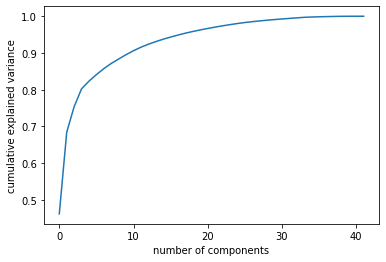

In [19]:
# Scale all variables...

robustScaler_venues_features = sklearn.preprocessing.RobustScaler().fit_transform(venues_features.values)

# ... and apply the Principal Component Analysis to find the components that best describe the variance in all dimensions of the data. 
# Then we can see the relationship between the number of components chosen and how much of the total variability in the data can be explained. 
pca_comp = PCA().fit(robustScaler_venues_features)
plt.plot(np.cumsum(pca_comp.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [20]:
# Finding how many components must be taken into account to preserve a given proportion of the data. 
pca_model = PCA(n_components=0.9, svd_solver='full') # preserving 90% of the variance in data.
pca_components = pca_model.fit_transform(robustScaler_venues_features)
pca_model.n_components_  

11

In [39]:
df_reduced = pd.DataFrame(data=cities_grouped_merge_population.city)
for i in range(len(pca_components[1])):
    df_reduced['Comp_{}'.format(i+1)] = pca_components[:,i]

In [40]:
df_reduced.head(10)

city    Comp_1    Comp_2    Comp_3    Comp_4    Comp_5  \
0           Abilene, Texas -1.922251 -1.431721 -1.525374 -0.342897  0.590004   
1              Akron, Ohio -0.925191 -1.197520  0.140646  0.389967 -0.206475   
2  Albuquerque, New Mexico  2.090702  0.466493  0.223559  3.355085 -0.538677   
3             Allen, Texas -1.936951 -1.510229 -1.425570 -0.429371 -0.053632   
4  Allentown, Pennsylvania -1.403629 -0.989507  0.638189 -0.330583  0.384214   
5          Amarillo, Texas -1.200334 -1.490985 -0.981307 -0.239816  0.315553   
6      Anaheim, California  0.644483 -0.696481  3.721733 -1.609930 -1.455809   
7      Ann Arbor, Michigan -1.383926 -0.979119  0.703630 -0.673351  0.128133   
8      Antioch, California -2.064996 -1.714685 -2.476663 -0.158271  0.138376   
9         Arlington, Texas  0.392402 -1.547123 -0.419866  0.512679 -0.932096   

     Comp_6    Comp_7    Comp_8    Comp_9   Comp_10   Comp_11  
0  0.490673 -0.309318 -0.526003  0.164426 -0.710300 -0.466330  
1  0.905436  0.787722  1.334433  1.237463  0.359707  0.526349  
2  0.877908  0.853429  0.202866 -0.377289  1.680679 -1.615508  
3  0.341779 -0.064698 -0.095937  0.842257  0.754150  1.039140  
4 -0.911712  0.288640  0.963967  0.557654  0.778930  0.358372  
5 -0.307590 -1.033463 -0.525531 -1.020756 -0.011779  0.311306  
6 -0.659072 -0.719083 -1.466123  2.014747  0.044809 -1.454190  
7 -0.602843 -0.375733  0.484102 -0.810079 -0.474296 -0.560351  
8  0.554107 -0.224734  0.177452 -0.141957 -0.206444  0.552845  
9 -0.506143 -0.618908 -0.211140 -0.515368 -0.181332 -0.168862

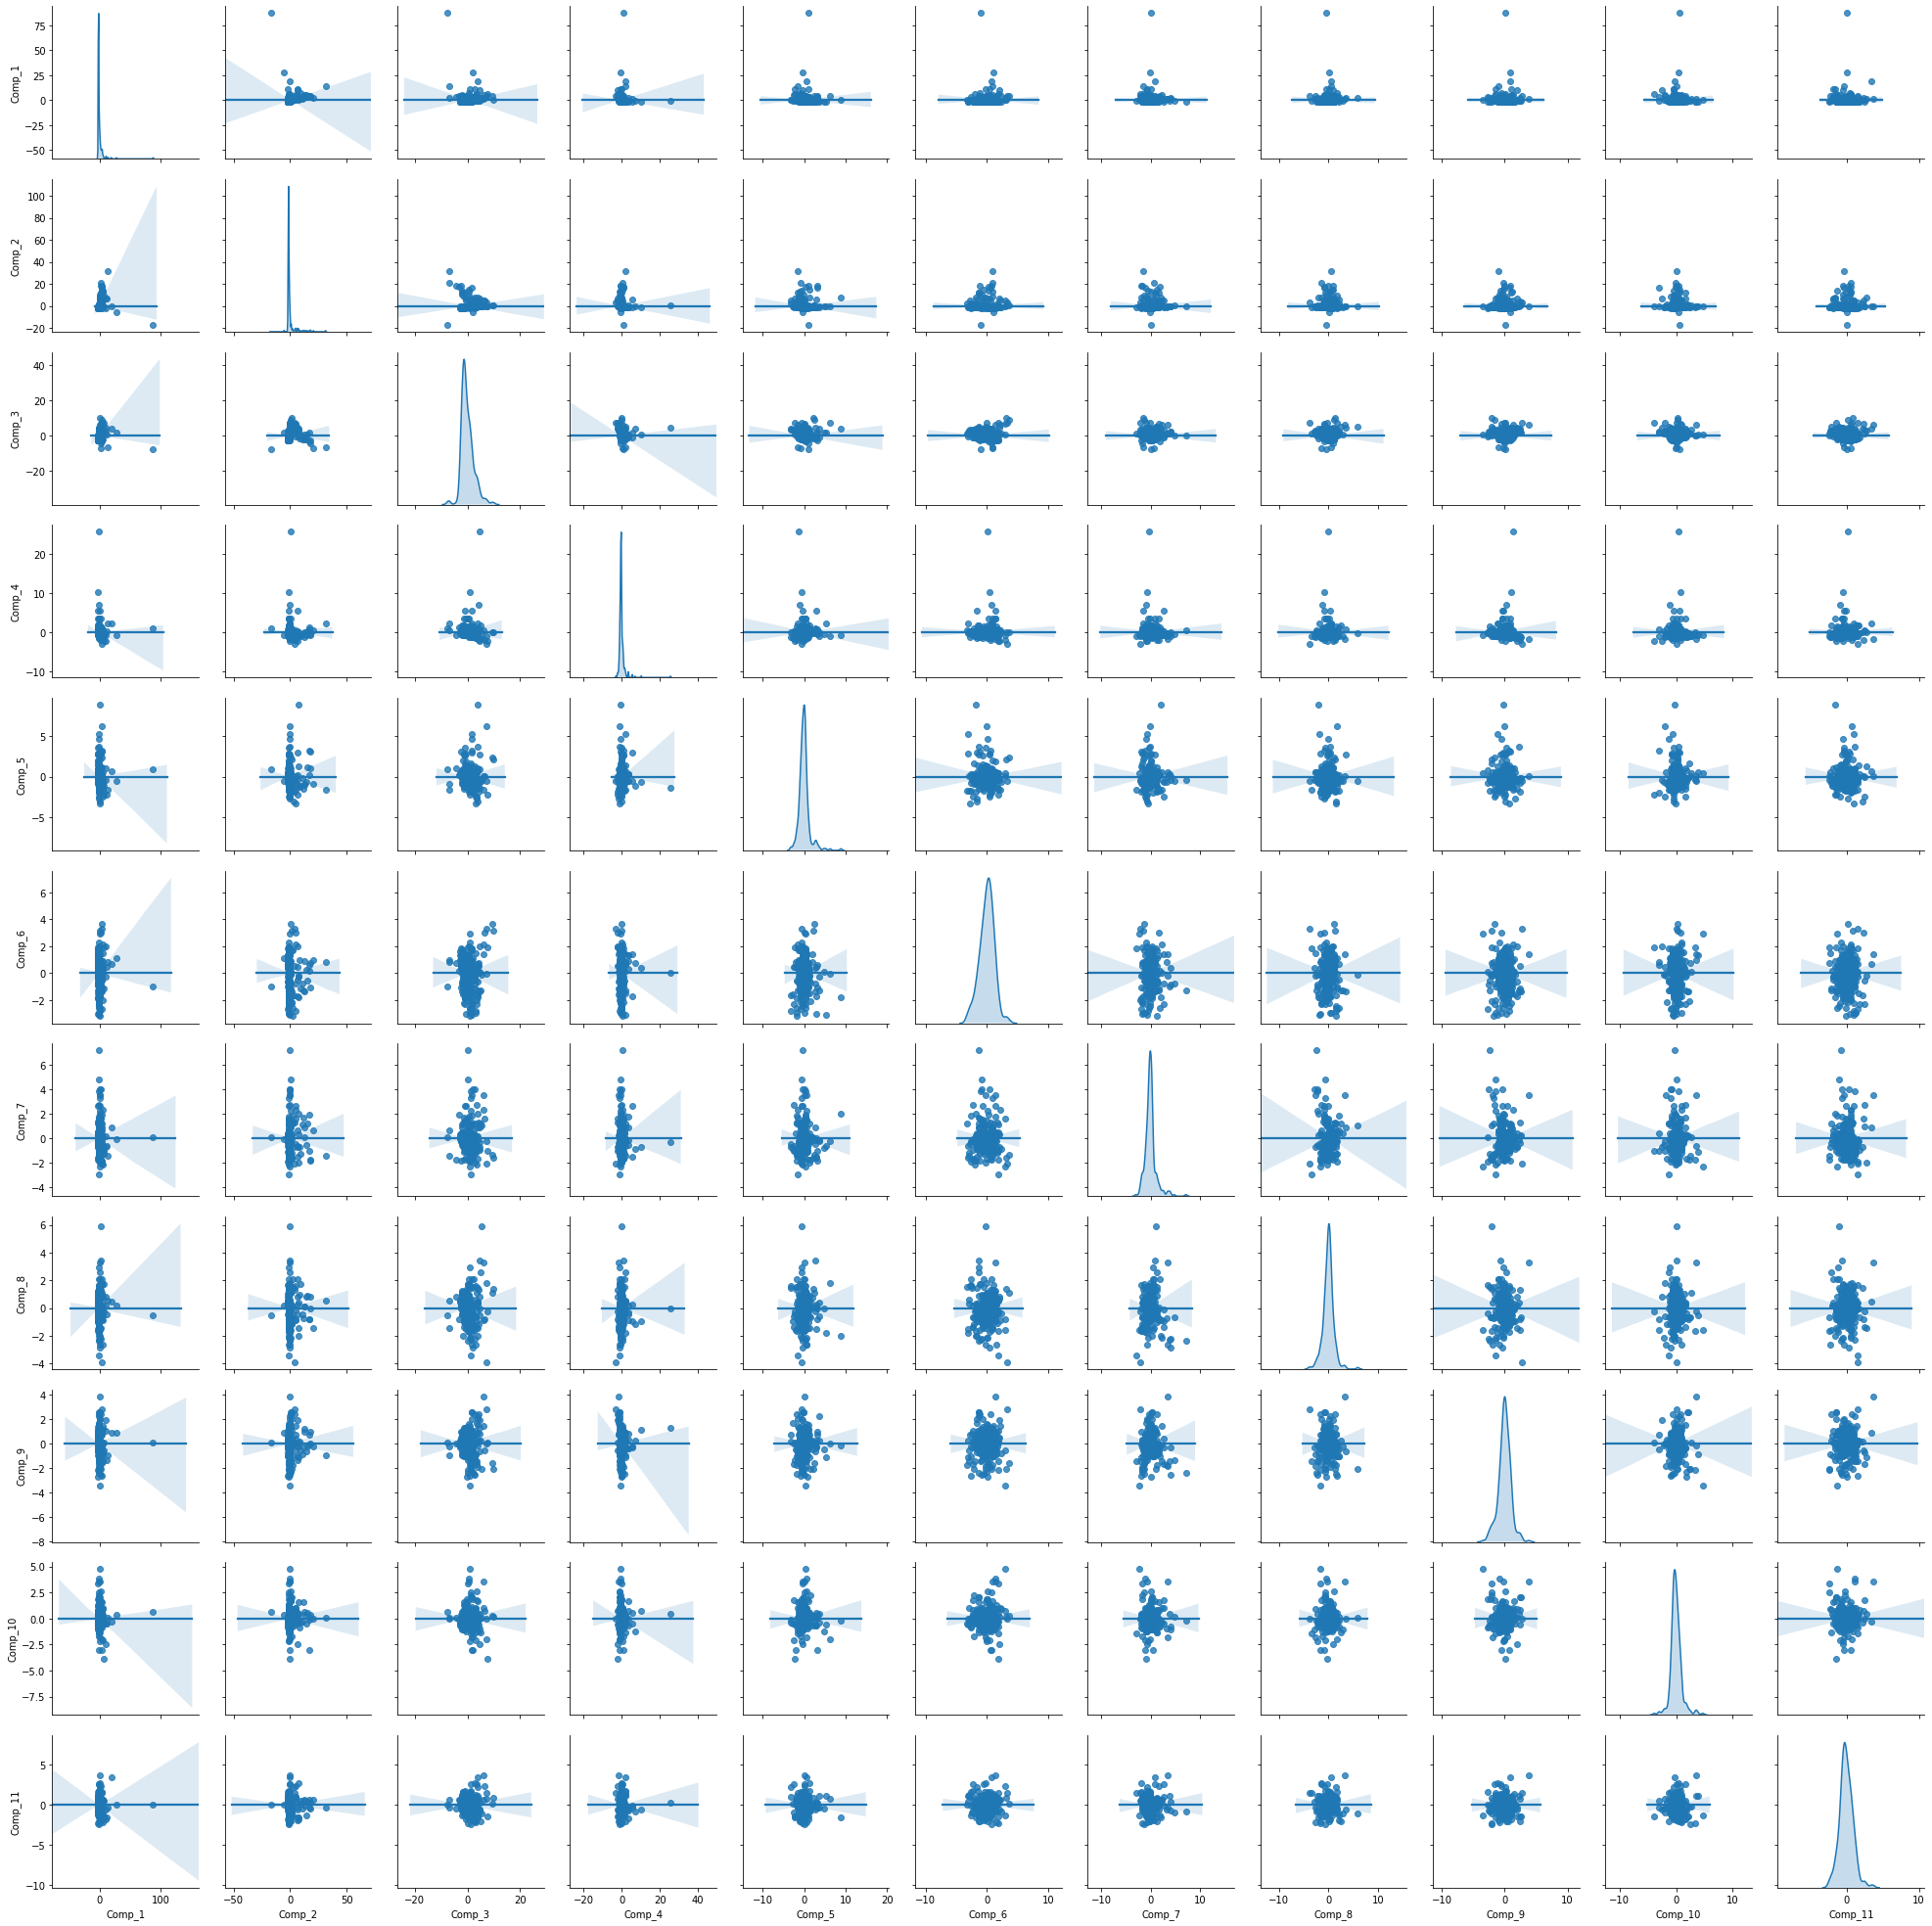

In [41]:
# Let's visualize these components to make sure they are orthogonal. 

sns.pairplot(df_reduced.iloc[:, 1:], kind = 'reg', diag_kind = 'kde')

### Clustering

Use these components as features for the clustering algorithm. 

HDBSCAN seems to be the most fitting for making no assumptions regarding the shape of the clusters and include noise. 

In [24]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=4, gen_min_span_tree=True)

clusterer.fit(pca_components)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_epsilon=0.0,
    cluster_selection_method='eom', core_dist_n_jobs=4,
    gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(location=None),
    metric='euclidean', min_cluster_size=4, min_samples=None, p=None,
    prediction_data=False)

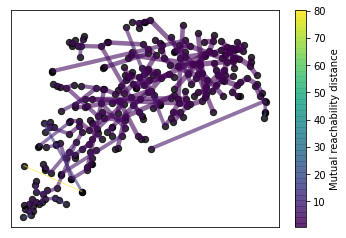

In [25]:
# The model measures the distance between the data points, finding areas with higher density. 
# The points are connected by edges with weight that represent the mutual reachability between any two points. 
# The darker the color of the edges in the figure below the closer the points. 

clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis', 
edge_alpha = 0.6, 
node_size = 40, 
edge_linewidth = 1)

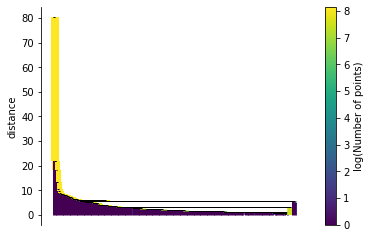

In [26]:
# Now we build a cluster hierarchy.
# A threshold is set high, and is steadily lowered. Edges above the threshold are dropped, disconnecting the graph into connected components. 
# The result is a hierarchy of connected components at varying threshold levels. 
# To define clusters we find the minimal set of edges such that dropping any edge from the set causes a disconnection of the components, and make sure that there's no edge with lower weight outside the cluster that could connect the components.

clusterer.single_linkage_tree_.plot(cmap='viridis' , colorbar=True)

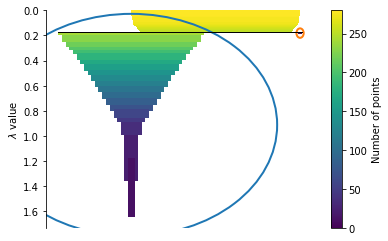

In [28]:
# We can condense this cluster hierarchy into smaller tree. We can visualize each dividing cluster as a cluster that is losing edges. 
# We already defined the minimum_cluster_size, that is the smallest group of connected points that we still consider a cluster. 
# If a disconnected edge splits the cluster and the remaining data points are less than the minimum_cluster_size, then those fall out of the cluster. 
# If not, it's considered a new cluster, and now there's a ramification in the tree. 
# Those disconnecting edges are stacked and plotted against the threshold below. The clusters are identified with ellipses around them. 

clusterer.condensed_tree_.plot(select_clusters=True, selection_palette = sns.color_palette())

In [29]:
# We can visualize these clusteres detected in the dimensions of the PCA output using a 3d plot of the 3 first components of the PCA. 
# The plot_clusters() function will create the visualizations. 

plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

def plot_clusters(data, algorithm, args, kwds):
    labels = algorithm(*args, **kwds).fit_predict(data)
    fig = plt.figure()
    ax = plt.axes(projection = '3d')
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in labels]
    ax.scatter3D(data.T[0], data.T[1], data.T[2], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    frame.axes.get_zaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=18)

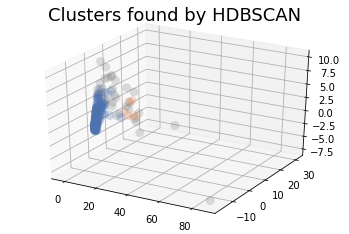

In [30]:
# Now we plot the scatterplot in 3D

plot_clusters(pca_components, hdbscan.HDBSCAN, (), {'min_cluster_size': 4})

In [42]:
# Let's add the cluster labels just found to the dataframe containing the components of PCA and check how many different clusters are there. The value "-1" is code for indetected cluster. 

df_reduced['cluster'] = clusterer.labels_
df_reduced['cluster'].unique()

array([ 0, -1,  1])



### Evaluation



In [44]:
# Now we create an object containing the features for the city of the tourist from out example. 
reference = df_reduced[df_reduced['city'] == home].iloc[0,1:]
df_reduced[df_reduced['city'] == home]

city     Comp_1     Comp_2    Comp_3  \
15  Avenida Paulista, Sao Paulo, Brazil  87.216291 -17.140746 -7.484166   

      Comp_4    Comp_5    Comp_6    Comp_7    Comp_8   Comp_9   Comp_10  \
15  1.015224  0.921903 -0.987519  0.117629 -0.530033  0.04645  0.605193   

     Comp_11  cluster  
15  0.053225       -1

In [45]:
# Calculate the distances from our reference city to all other data cities and add them to a list. 

distances = []

for i in range(len(df_reduced['city'])):
    distances.append(np.linalg.norm(reference - df_reduced.iloc[i, 1:]))

df_reduced['distances'] = distances

In [46]:
# Adding the population as a feature
df_merged = pd.merge(left = df_reduced, right = df, left_on='city', right_on='city', how = 'left')
df_merged.head(10)

city    Comp_1    Comp_2    Comp_3    Comp_4    Comp_5  \
0           Abilene, Texas -1.922251 -1.431721 -1.525374 -0.342897  0.590004   
1              Akron, Ohio -0.925191 -1.197520  0.140646  0.389967 -0.206475   
2  Albuquerque, New Mexico  2.090702  0.466493  0.223559  3.355085 -0.538677   
3             Allen, Texas -1.936951 -1.510229 -1.425570 -0.429371 -0.053632   
4  Allentown, Pennsylvania -1.403629 -0.989507  0.638189 -0.330583  0.384214   
5          Amarillo, Texas -1.200334 -1.490985 -0.981307 -0.239816  0.315553   
6      Anaheim, California  0.644483 -0.696481  3.721733 -1.609930 -1.455809   
7      Ann Arbor, Michigan -1.383926 -0.979119  0.703630 -0.673351  0.128133   
8      Antioch, California -2.064996 -1.714685 -2.476663 -0.158271  0.138376   
9         Arlington, Texas  0.392402 -1.547123 -0.419866  0.512679 -0.932096   

     Comp_6    Comp_7    Comp_8    Comp_9   Comp_10   Comp_11  cluster  \
0  0.490673 -0.309318 -0.526003  0.164426 -0.710300 -0.466330        0   
1  0.905436  0.787722  1.334433  1.237463  0.359707  0.526349        0   
2  0.877908  0.853429  0.202866 -0.377289  1.680679 -1.615508        0   
3  0.341779 -0.064698 -0.095937  0.842257  0.754150  1.039140        0   
4 -0.911712  0.288640  0.963967  0.557654  0.778930  0.358372        0   
5 -0.307590 -1.033463 -0.525531 -1.020756 -0.011779  0.311306        0   
6 -0.659072 -0.719083 -1.466123  2.014747  0.044809 -1.454190        0   
7 -0.602843 -0.375733  0.484102 -0.810079 -0.474296 -0.560351        0   
8  0.554107 -0.224734  0.177452 -0.141957 -0.206444  0.552845        0   
9 -0.506143 -0.618908 -0.211140 -0.515368 -0.181332 -0.168862        0   

   population   latitude   longitude  
0      123420  32.446449  -99.747589  
1      197597  41.083065  -81.518486  
2      560513  35.084103 -106.650986  
3      105623  33.103176  -96.670547  
4      121442  40.602207  -75.471283  
5      199371  35.207218 -101.833824  
6      350365  33.834751 -117.911736  
7      119980  42.268158  -83.731232  
8      111502  38.004921 -121.805786  
9      398854  32.701939  -97.105621

In [52]:
# And we create a final dataframe with the features of interest for posterior visualizations of the clusters. 

df_final = pd.DataFrame(df_merged['city'])
df_final['latitude'] = df_merged['latitude']
df_final['longitude'] = df_merged['longitude']
df_final['cluster'] = df_reduced['cluster']
df_final['distances'] = distances

df_final = df_final.dropna()

In [53]:
df_final.sort_values(by=['distances']).head(10)

city   latitude   longitude  cluster  \
15   Avenida Paulista, Sao Paulo, Brazil -23.557000  -46.661248     -1.0   
134              Los Angeles, California  34.053692 -118.242767      0.0   
41                     Chicago, Illinois  41.875561  -87.624420     -1.0   
184                     Phoenix, Arizona  33.448437 -112.074142      0.0   
213                   San Antonio, Texas  29.424601  -98.495140      0.0   
60                         Dallas, Texas  32.776272  -96.796852     -1.0   
215                 San Jose, California  37.336189 -121.890587     -1.0   
14                         Austin, Texas  30.271128  -97.743698     -1.0   
39             Charlotte, North Carolina  35.227200  -80.843086      0.0   
54                        Columbus, Ohio  39.962261  -83.000710     -1.0   

     distances  
15    0.000000  
134  61.234272  
41   71.037046  
184  78.696996  
213  80.259947  
60   81.735283  
215  83.510520  
14   84.239382  
39   84.735571  
54   84.819167

#### According to this analysis, the closest city to Sao Paulo, all features considered, would be Los Angeles. 

Let's see the map with the cluster labels as color code. 


In [54]:
map_clusters = folium.Map(location=[df_final['latitude'][0], df_final['longitude'][0]], zoom_start=3)

# set color scheme for the clusters
x = np.arange(len(df_final['cluster'].unique()))
ys = [i + x + (i*x)**2 for i in range(len(df_final['cluster'].unique()))]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_final['latitude'], df_final['longitude'], df_final['city'], df_final['cluster'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters